Challenge: model comparison

You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [1]:
# Import some packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.mlab
import scipy
from scipy import stats
from sklearn.preprocessing import normalize, scale, StandardScaler
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sqlalchemy import create_engine


import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Connect to the data base:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format( postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

In [3]:
# Look at the dataset:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
# Exploring Nulls and type of data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
# Findout missing values:
sum_null_columns = df.isnull().sum().sort_values(ascending=False)
percent_null_columns = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([sum_null_columns, percent_null_columns], axis=1, keys=['sum_null_columns', 'percent_null_columns'])
missing_data.head(20)

,sum_null_columns,percent_null_columns
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
lotfrontage,259,17.739726
garagecond,81,5.547945
garagetype,81,5.547945
garageyrblt,81,5.547945
garagefinish,81,5.547945


In [6]:
# Findout numeric column with missing values:
numeric_columns = df.select_dtypes(exclude=['object']).columns
missing_columns = [col for col in numeric_columns if df[col].isnull().any()]

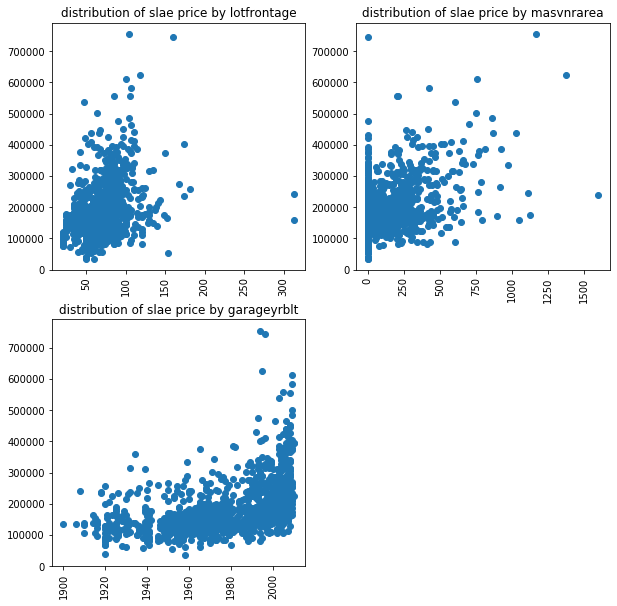

In [7]:
# Look at the distribution of target variable with missing value columns:
plt.figure(figsize=(10,10))
for i,column in enumerate(missing_columns):
    plt.subplot(2, 2, i+1)
    plt.scatter(df[column], df['saleprice'])
    plt.title(f'distribution of slae price by {column}')
    plt.xticks(rotation=90)

plt.show()

I think based on the scatter plot the relationship between target variable and missing columns have bussinus meaning because of linear relationship.

In [8]:
# Dropping columns which have more than 45% missing values:
cols = df.columns[df.isnull().sum()*100/df.isnull().count()>45.00]
df = df.drop(cols, axis=1)

In [9]:
# Clean dataset by droping duplicates:  
df.drop_duplicates(inplace=True) 

In [10]:
# Findout numeric columns:
numeric_columns = df.select_dtypes(exclude=['object']).columns
print(numeric_columns)
print('Number of numeric columns is {}'.format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
Number of numeric columns is 38


In [11]:
# Filling numeric columns:
for column in numeric_columns:
    df.loc[:,numeric_columns] = df.loc[:,numeric_columns].interpolate() 

In [12]:
# Findout nonnumeric columns:
nonnumeric_columns=df.select_dtypes('object').columns
print(nonnumeric_columns)
print('number of nonnumeric columns is {}'.format(len(nonnumeric_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'saletype', 'salecondition'],
      dtype='object')
number of nonnumeric columns is 38


In [13]:
# Filling nonnumeric columns:
for i in range(1,len(df)):
    df.loc[i,nonnumeric_columns]=df.loc[i,nonnumeric_columns].fillna(df.loc[i-1,nonnumeric_columns])

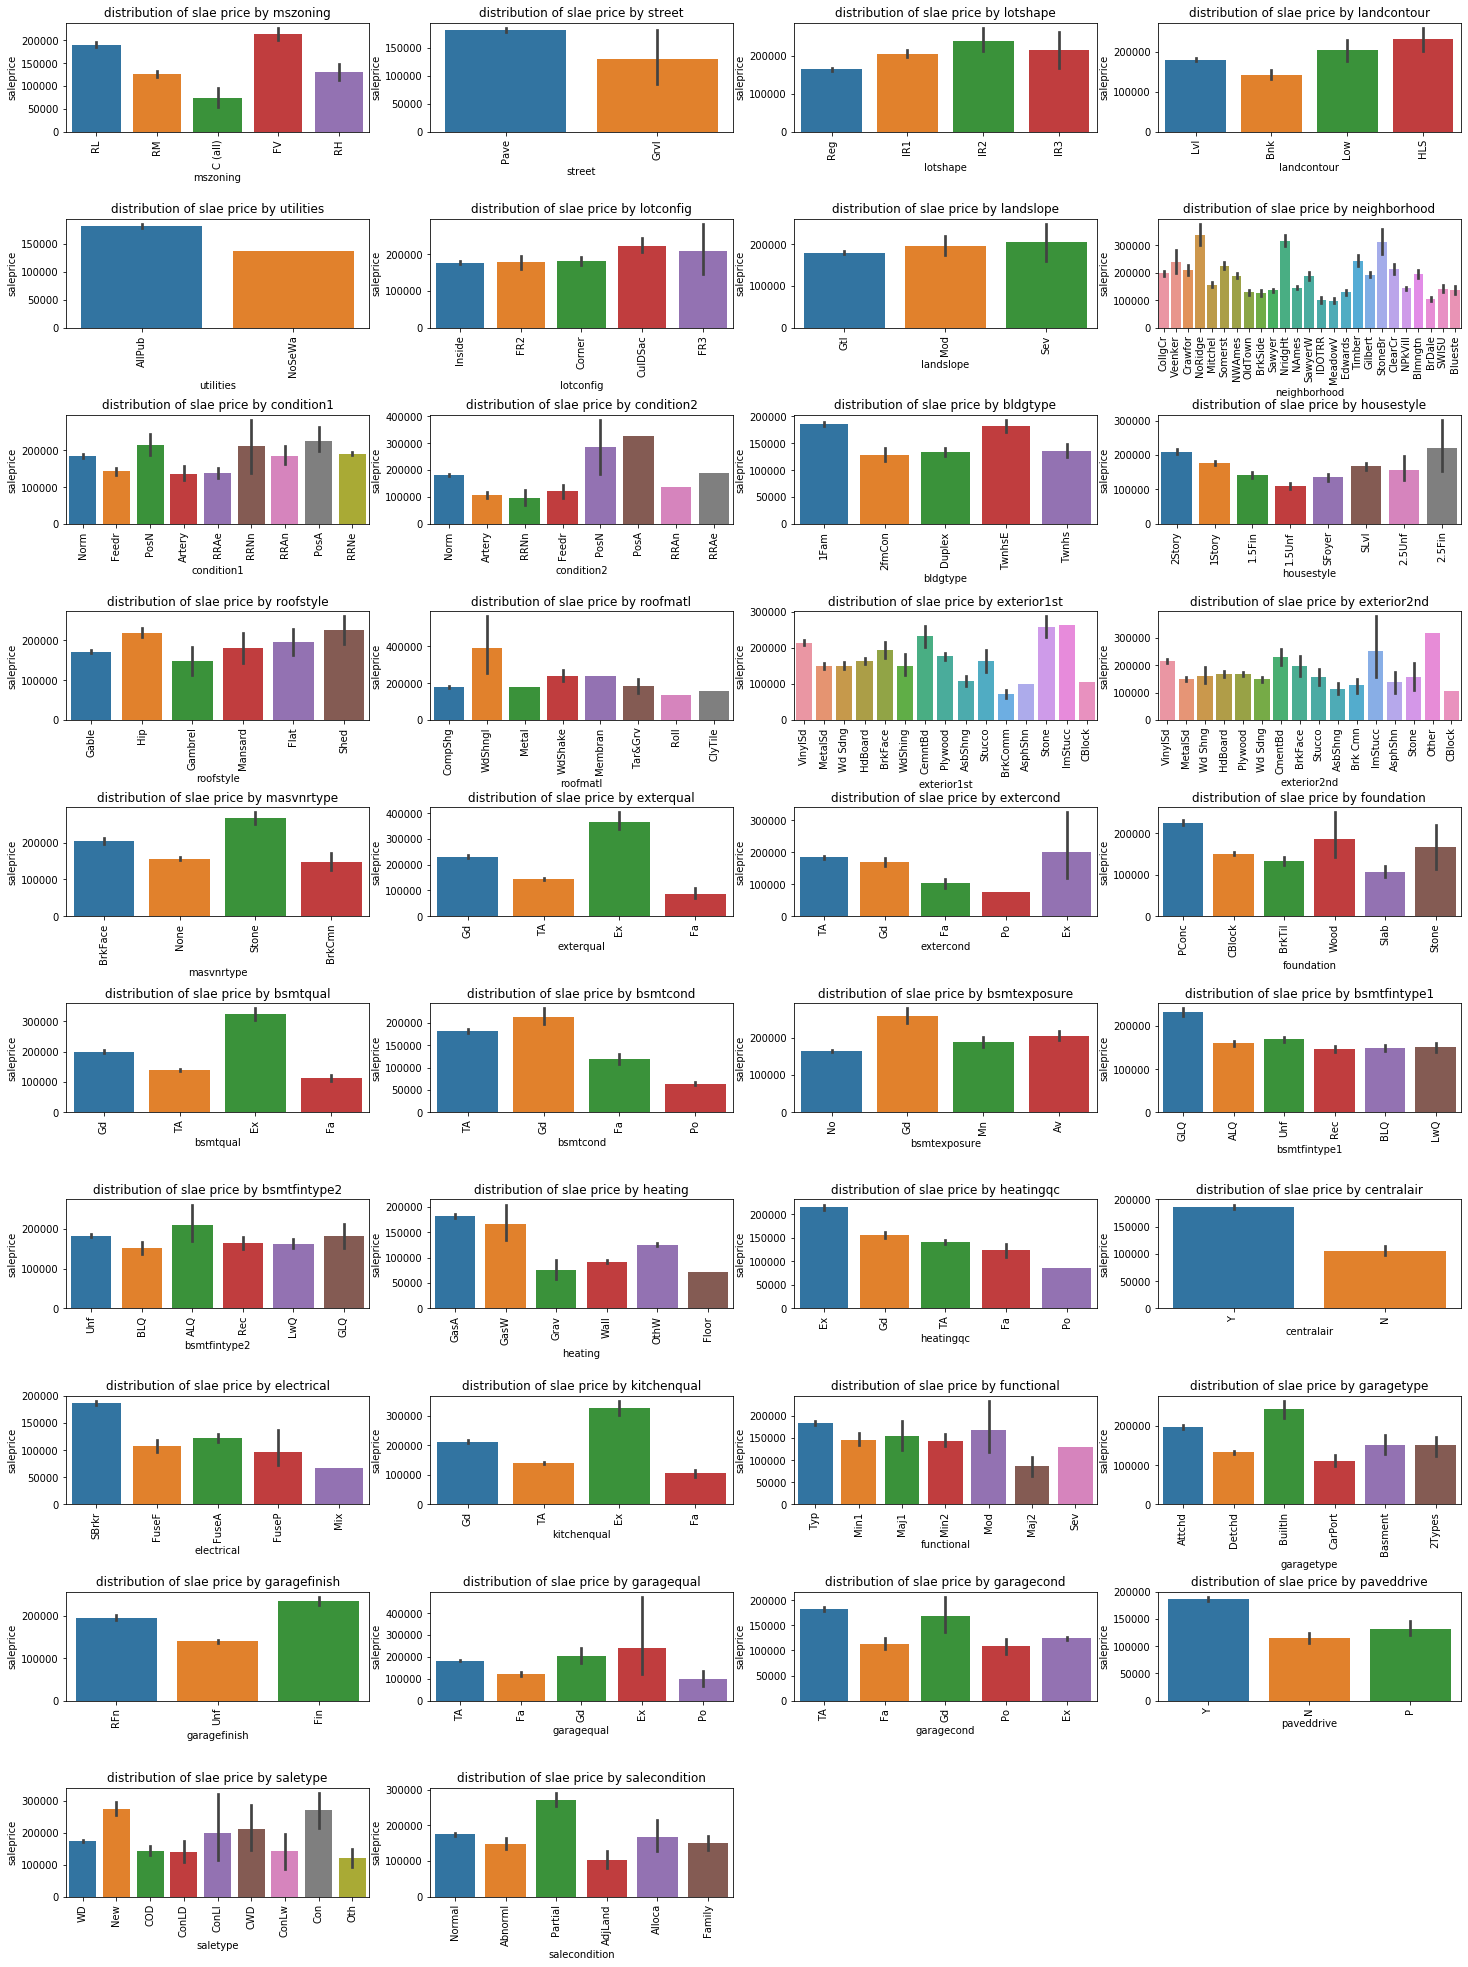

In [14]:
# Look at the distribution of target variable with nonnumeric columns:
plt.figure(figsize=(25,50))
for i,column in enumerate(nonnumeric_columns):
    plt.subplot(11, 4, i+1)
    sns.barplot(df[column], df['saleprice'])
    plt.title(f'distribution of slae price by {column}')
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.8, top = 0.7)
plt.show()

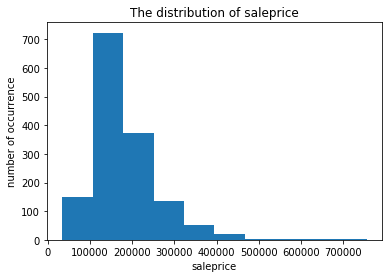

In [15]:
# Look at the distribution of target variable(saleprice):
plt.hist(df.saleprice)
plt.title("The distribution of saleprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurrence")
plt.show()

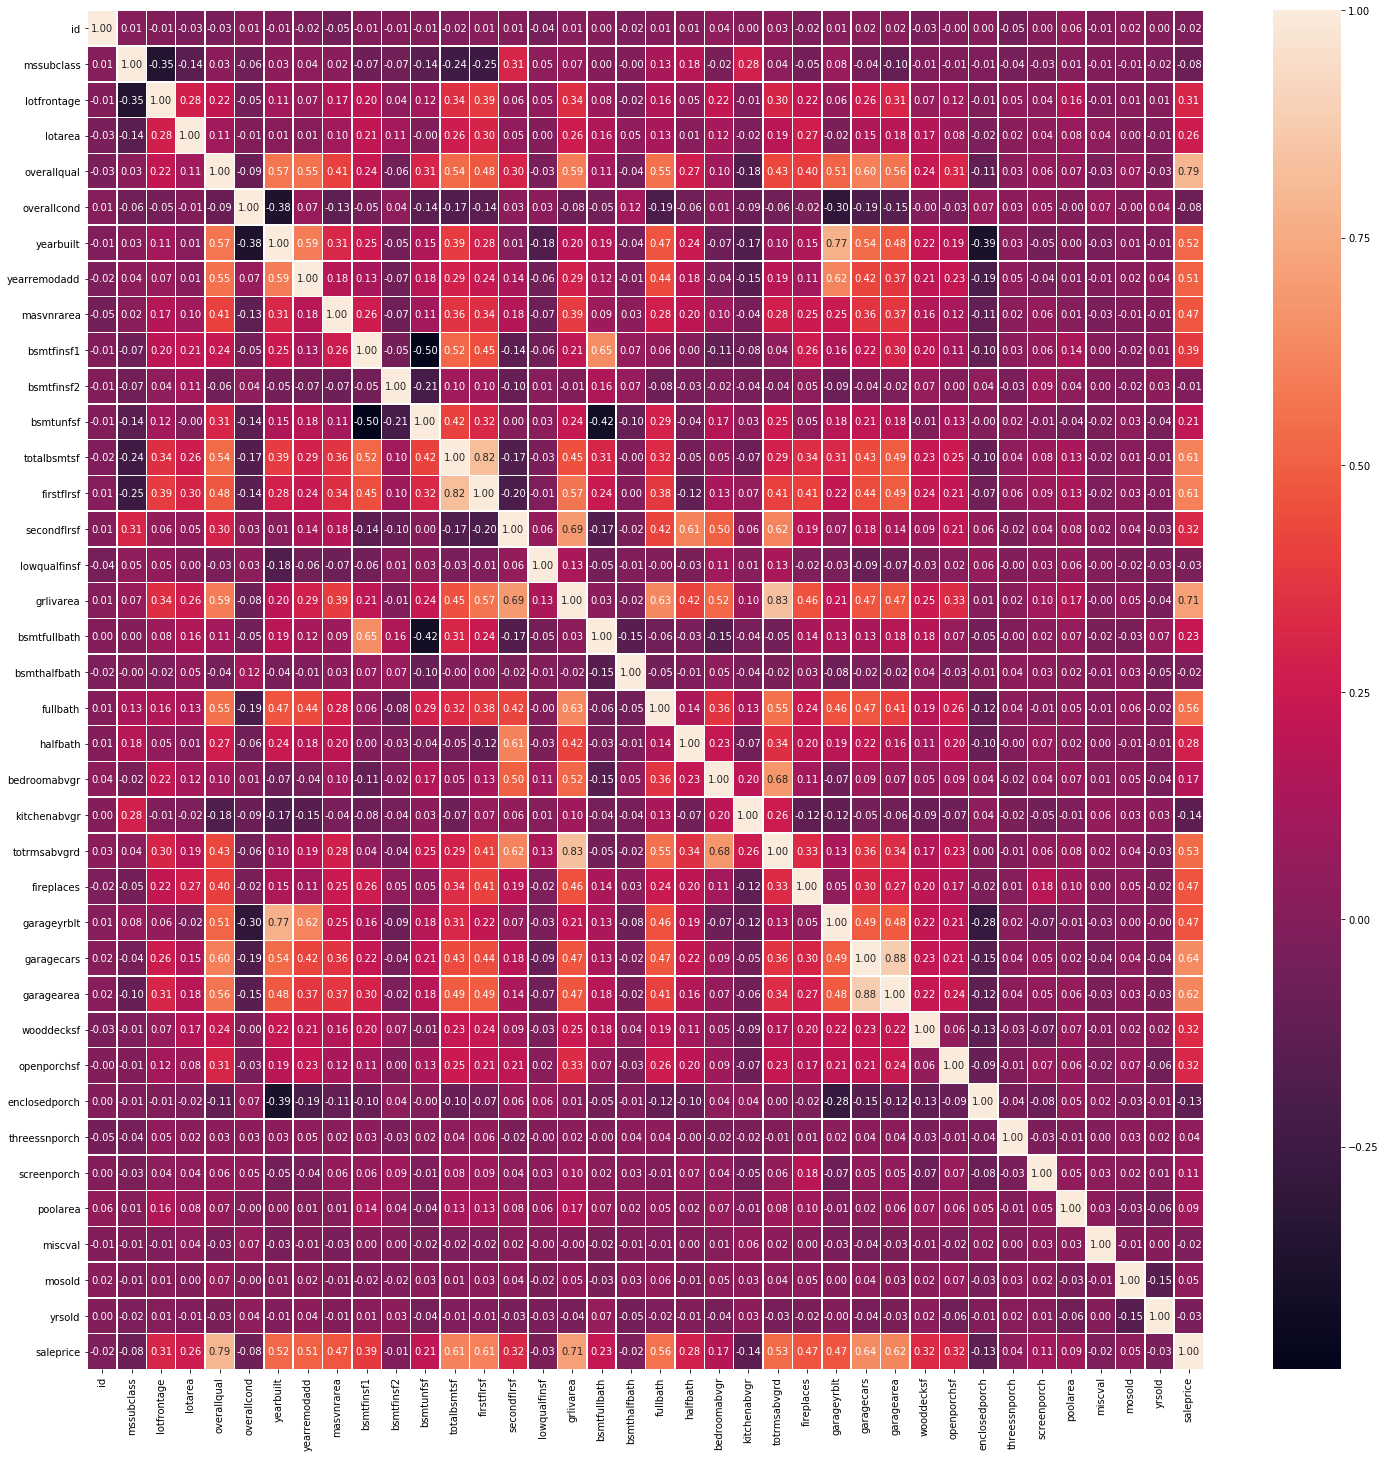

In [16]:
# Look at the correlationship between target variable and countinues columns:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f')

In [17]:
# The categorical variables are strings and we need to convert them to the numerical values.
categorical = df.select_dtypes(include=['object'])
dummies = pd.get_dummies(categorical, drop_first=True)
dummies.head()

,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,...,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [18]:
# Drop nonnumeric columns variables after converting to dummies: 
df = df.drop(list(categorical.columns), axis=1)
df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [19]:
# Concat dummies variables with dataset:
df = pd.concat([df, dummies], axis=1)
df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,1,0


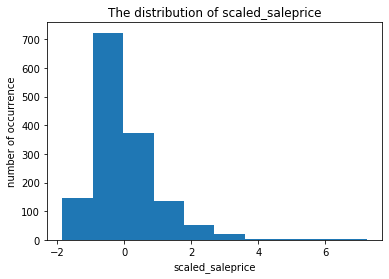

In [20]:
# For meodeling we have to assume the target variable to be normally distributed, so we can use standardized:
df["scaled_saleprice"] = scale(df["saleprice"])

plt.hist(df.scaled_saleprice)
plt.title("The distribution of scaled_saleprice")
plt.xlabel("scaled_saleprice")
plt.ylabel("number of occurrence")
plt.show()

Now modeling the saleprice houses.I choose 4 high correlationship variables between target variable and continuse variables; also, I choose two high correlationship of categorical variables with target variable, then using all of them to model.  

saleprice:y = 𝛽0+𝛽1 overallqual + 𝛽2 grlivarea + 𝛽3 garagecars + 𝛽4 totalbsmtsf +𝛽5 exterqual_TA +𝛽6 kitchenqual_TA +𝜖

In [21]:
# Now we build a model:

# Y is the target variable:
Y = df['saleprice']
# X is the feature set:
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'exterqual_TA', 'kitchenqual_TA']]

In [22]:
# Split dataset:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


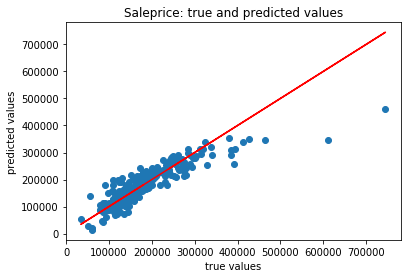

R-squared of the model in the training set is: 0.7648068127712628
-----Test set statistics-----
R-squared of the model in the test set is: 0.7743082404503732
Mean absolute error of the prediction is: 25541.75503723135
Mean squared error of the prediction is: 1515227686.701587
Root mean squared error of the prediction is: 38925.92563705566
Mean absolute percentage error of the prediction is: 15.43239837917886


In [23]:
# We fit an OLS model using sklearn:
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
lrm_y_preds_train = lrm.predict(X_train)
lrm_y_preds_test = lrm.predict(X_test)

plt.scatter(y_test, lrm_y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Saleprice: true and predicted values")
plt.show()

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, lrm_y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, lrm_y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, lrm_y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - lrm_y_preds_test) / y_test)) * 100))

As we see, the R-squared of the model in the training set is 0.76; also, R-squared of the model in the test set is 0.77.

In [24]:
# Get the average of scores:
score = cross_val_score(lrm, X_train, y_train, cv=5)
print('Accuracy of training set in ols model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

score = cross_val_score(lrm, X_test, y_test, cv=5)
print('Accuracy of test set in ols model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))




Accuracy of training set in ols model: 0.76 (+/- 0.16)
Accuracy of test set in ols model: 0.78 (+/- 0.13)
Accuracy of training set in ols model: 1.00 (+/- 0.00)
Accuracy of test set in ols model: 1.00 (+/- 0.00)


As you can see, the average score of accuracy in linear regression model is around 0.78, also sandard deviation of model is around 0.13 which is small and that means our model is relatively consistent with different hold out and doesn't seem overfitting.

Now build the model with knn, because the target variable in this dataset (saleprice) is continuse, so using knn regression instead of knn classification.

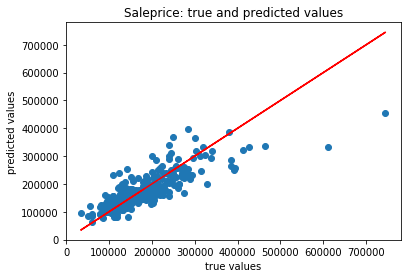

In [25]:
# Now using knn regression algorithm:

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)

# Fit the model:
knn.fit(X_train, y_train) 

# Predict the model:
knn_y_preds_train = knn.predict(X_train)
knn_y_preds_test = knn.predict(X_test)


plt.scatter(y_test, knn_y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Saleprice: true and predicted values")
plt.show()

In [26]:
# Average the scores:
score = cross_val_score(knn, X_train, y_train, cv=5)
print('Unweighted Accuracy of training set in knn model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

score = cross_val_score(knn, X_test, y_test, cv=5)
print('Unweighted Accuracy of test set in knn model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))


Unweighted Accuracy of training set in knn model: 0.63 (+/- 0.07)
Unweighted Accuracy of test set in knn model: 0.64 (+/- 0.20)
Unweighted Accuracy of training set in knn model: 0.96 (+/- 0.02)
Unweighted Accuracy of test set in knn model: 0.88 (+/- 0.03)


As you can see, the average score of accuracy in knn regression model is around 0.64, also sandard deviation of model is around 0.2 which is small and that means our model is relatively consistent with different hold out and doesn't seem overfitting.

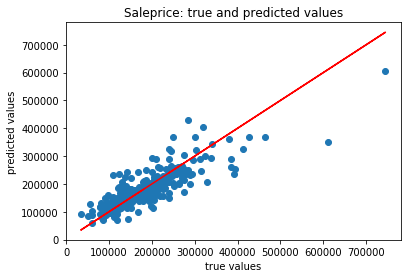

In [27]:
# Run the same model, this time with weights:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')

# Fit the model:
knn_w.fit(X_train, y_train)

# Predict the model wih weight:
knn_w_y_preds_train = knn_w.predict(X_train)
knn_w_y_preds_test = knn_w.predict(X_test)

plt.scatter(y_test, knn_w_y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Saleprice: true and predicted values")
plt.show()

In [28]:
# Average the scores:
score = cross_val_score(knn_w, X_train, y_train, cv=5)
print('Weighted Accuracy of training set in knn model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

score = cross_val_score(knn_w, X_test, y_test, cv=5)
print('Weighted Accuracy of test set in knn model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))




Weighted Accuracy of training set in knn model: 0.61 (+/- 0.07)
Weighted Accuracy of test set in knn model: 0.63 (+/- 0.18)
Weighted Accuracy of training set in knn model: 0.61 (+/- 0.07)
Weighted Accuracy of test set in knn model: 0.87 (+/- 0.06)


As you can see, the average score of accuracy in knn regression model with weight is around 0.63, also sandard deviation of model is around 0.18 which is small and that means our model is relatively consistent with different hold out and doesn't seem overfitting.

- Compare the two model. How similar are they? Do they miss in different ways?

For comparing two model, I compare the average cross validation score of linear regression with knn regression model, I think the linear regression with higher score is better than knn regression model. Because, cross validation score shows performance of model and accuracy, so higher score means better performance.



- How similar are they? Do they miss in different ways?

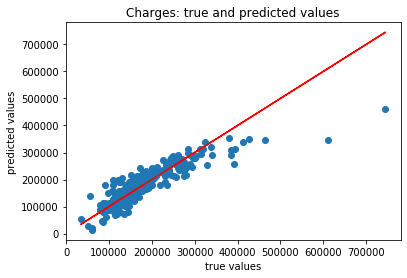

In [35]:
plt.scatter(y_test, lrm_y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

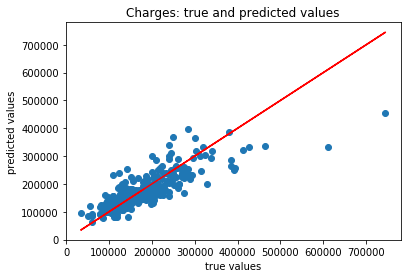

In [30]:
plt.scatter(y_test, knn_y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

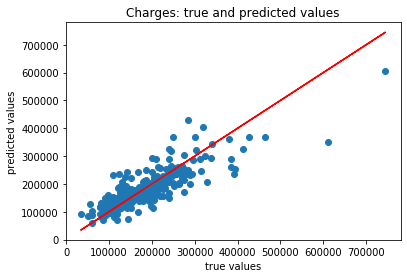

In [31]:
plt.scatter(y_test, knn_w_y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

- Similarity: As you can see in above plots, we see that our models predicts the lower values of the target variable better than the higher values. 
- differences: The ols model seems to better predict low values of the target variable, because the points are more tightly clustered around the red line. but generally two models in this dataset are almost the same result.

- Describe the models' behaviors?and why you favor one model or the other?

I think my favor model for this dataset is linear regression model, because it has a higher cross validation score which shows better performance and accuracy.

- Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other?

If by using grid search improve knn model's parameter and the score of accuracy get higher than ols model, we can change our mind.

- Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

